# Recalibrating the Brunt equation using Eureka data

## Jason Kniss
### Feb 14 2024

This script is used to process the unfiltered code, intended as a test of
functionality and for the author to practice python coding

### Import Libraries

In [1]:
import pandas as pd
import os
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import HTML
from pandasgui import show

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Import data

In [3]:
data_df = pd.read_csv('eureka-data.csv', index_col=0, parse_dates=True)

#### Create tool for selecting filters

#### Choose to use bsrn LWD or tower LWD

Comment out the other

In [4]:
# To use bsrn
data_df.rename(columns={'bsrnLWTotalDownwelling[W/m^2]': 'LWTotalDownwelling[W/m^2]'}, inplace=True)

# To use tower
# data_df.rename(columns={'twrLWTotalDownwelling[W/m^2]': 'LWTotalDownwelling[W/m^2]'}, inplace=True)

## Calculate effective emissivity

### Calculate effective emissivity from measured DLR and Temperature

$\varepsilon = \frac{\rm DLR}{\sigma T_a}$

In [5]:
SIGMA = 5.67e-8

In [6]:
# Convert temperature from Celsius to Kelvin

data_df['T2_K'] = data_df['2MVTair[degC]'] + 273.15 
# data_df['T6_K'] = data_df['6MVTair[degC]'] + 273.15 
data_df['T10_K'] = data_df['10MVTair[degC]'] + 273.15 

# Calculate effective emissivity
data_df['eps2'] = data_df['LWTotalDownwelling[W/m^2]'] / (SIGMA * data_df['T2_K']**4)
# data_df['eps6'] = data_df['LWTotalDownwelling[W/m^2]'] / (SIGMA * data_df['T6_K']**4)
data_df['eps10'] = data_df['LWTotalDownwelling[W/m^2]'] / (SIGMA * data_df['T10_K']**4)

## Calculate expected DLR 

The Brunt form of the equation for clear sky emissivity is:

$\varepsilon_c = c_1 + c_2\sqrt{P_w}$


*This step will come after fitting a power curve to the measured DLR data*

Calculate Partial Pressure of water vapor (hPa)

In [7]:
data_df['Pw2'] = 610.94*(data_df['2MRH[%]']/100)*np.exp((17.625*(data_df['T2_K'] - 273.15))/(data_df['T2_K'] - 30.11))/100
# data_df['Pw6'] = 610.94*(data_df['6MRH[%]']/100)*np.exp((17.625*(data_df['T6_K'] - 273.15))/(data_df['T6_K'] - 30.11))/100
data_df['Pw10'] = 610.94*(data_df['10MRH[%]']/100)*np.exp((17.625*(data_df['T10_K'] - 273.15))/(data_df['T10_K'] - 30.11))/100

Calculate clear sky emissivity
*Parameters per the original Brunt equation. **Don't Run both emissivity cells***


In [8]:
# data_df['e2'] = (0.52 + 0.065*np.sqrt(data_df['Pw2']))
# # data_df['e6'] = (0.52 + 0.065*np.sqrt(data_df['Pw6']))
# data_df['e10'] = (0.52 + 0.065*np.sqrt(data_df['Pw10']))

Calculate clear sky emissivity
*Calibrated parameters per Li et al. 2017. **Don't Run both emissivity cells***

In [9]:
data_df['e2'] = (0.618 + 0.054*np.sqrt(data_df['Pw2']))
# data_df['e6'] = (0.618 + 0.054*np.sqrt(data_df['Pw6']))
data_df['e10'] = (0.618 + 0.054*np.sqrt(data_df['Pw10']))

Calculate expected DLR

In [10]:
data_df['DLR2'] = data_df['e2']*SIGMA*(data_df['T2_K']**4)
# data_df['DLR6'] = data_df['e6']*SIGMA*(data_df['T6_K']**4)
data_df['DLR10'] = data_df['e10']*SIGMA*(data_df['T10_K']**4)

Create a mask to filter out NaN values

*This may be unnecessary, NaN values may be automatically rejected*

In [11]:
# epsmask2 = data_df['eps2'].notna()
# epsmask6 = data_df['eps6'].notna()
# epsmask10 = data_df['eps10'].notna()
# DLRmask2 = data_df['DLR2'].notna() & data_df['LWTotalDownwelling[W/m^2]'].notna()
# DLRmask6 = data_df['DLR6'].notna() & data_df['LWTotalDownwelling[W/m^2]'].notna()
# DLRmask10 = data_df['DLR10'].notna() & data_df['LWTotalDownwelling[W/m^2]'].notna()

## Generate filters

#### Quality Control flags

In [12]:
# Come back to this when I figure out how to QC works

#### Outliers

Eliminate outliars (2 std deviations, rolling)

This must remain the first filter, as it is dependent upon the relationship between neighboring measurements in time

In [13]:
columns_to_filter = [
    'Pressure[mbar]',
    '10MRH[%]',
    '2MRH[%]',
    '10MVTair[degC]', 
    '2MVTair[degC]',
    'LWTotalDownwelling[W/m^2]'
]

In [14]:
# Parameters
window_size = 20 # Five minute window
z_score_threshold = 2 # two standard deviations

outlier_mask_df = pd.DataFrame(index=data_df.index)
z_scores_df = pd.DataFrame(index=data_df.index)

# iterate over each selected column
for column in columns_to_filter:
    # Calculate rolling mean and std deviation
    rolling_mean = data_df[column].rolling(window=window_size, center=True).mean()
    rolling_std = data_df[column].rolling(window=window_size, center=True).std()

    # Calculate z-score for the current column
    z_scores = (data_df[column] - rolling_mean) / rolling_std

    # Save Z-scores in the new DataFrame
    z_scores_df[column + '_z_score'] = z_scores
    
    # Filter outliers based on z_score threshold
    non_outlier_mask = (z_scores.abs() <= z_score_threshold) | pd.isna(z_scores)
    outlier_mask_df[column + '_is_not_outlier'] = non_outlier_mask

data_df['isnotoutlier'] = outlier_mask_df[[col + '_is_not_outlier' for col in columns_to_filter]].all(axis=1)
    
# outlier_mask = outlier_mask_df[[col + '_is_not_outlier' for col in columns_to_filter]].all(axis=1)
# data_df = data_df[outlier_mask]

In [15]:
# inverse_mask = ~outlier_mask

# show(ref_df)
# show(z_scores_df[inverse_mask])

#### RH cannot be negetive

In [16]:
data_df.loc[data_df['2MRH[%]'] < 0, '2MRH[%]'] = np.nan
# data_df.loc[data_df['6MRH[%]'] < 0, '6MRH[%]'] = np.nan
data_df.loc[data_df['10MRH[%]'] < 0, '10MRH[%]'] = np.nan

#### View Dataframes and Info

In [17]:
data_df.head()

,Pressure[mbar],10MRH[%],2MRH[%],10MVTair[degC],2MVTair[degC],twrLWTotalDownwelling[W/m^2],twrQualityControl,LWTotalDownwelling[W/m^2],bsrnQualityControl,T2_K,T10_K,eps2,eps10,Pw2,Pw10,e2,e10,DLR2,DLR10,isnotoutlier
Datetime,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,1009.8,64.315,61.374,-35.070,-35.680,182.150,9.000000e+10,NaN,NaN,237.470,238.080,NaN,NaN,0.180676,0.201160,0.640953,0.642219,115.569810,116.992544,True
2009-01-01 00:01:00,1009.8,62.975,60.589,-34.944,-35.755,182.109,9.000000e+10,150.10,9.091991e+15,237.395,238.206,0.833511,0.822218,0.177036,0.199441,0.640721,0.642116,115.382038,117.221471,True
2009-01-01 00:02:00,1009.8,63.003,59.687,-34.976,-35.828,182.317,9.000000e+10,150.48,9.091991e+15,237.322,238.174,0.836650,0.824742,0.173136,0.198899,0.640469,0.642083,115.194911,117.152512,True
2009-01-01 00:03:00,1009.7,63.520,59.662,-34.968,-35.864,182.290,9.000000e+10,150.36,9.091991e+15,237.286,238.182,0.836490,0.823974,0.172443,0.200690,0.640424,0.642191,115.116938,117.187994,True
2009-01-01 00:04:00,1009.6,65.087,60.625,-34.909,-35.860,182.319,9.000000e+10,150.57,9.091991e+15,237.290,238.241,0.837602,0.824308,0.175296,0.206844,0.640609,0.642559,115.157914,117.371395,True


In [18]:
data_df.describe()

,Pressure[mbar],10MRH[%],2MRH[%],10MVTair[degC],2MVTair[degC],twrLWTotalDownwelling[W/m^2],twrQualityControl,LWTotalDownwelling[W/m^2],bsrnQualityControl,T2_K,T10_K,eps2,eps10,Pw2,Pw10,e2,e10,DLR2,DLR10
count,217440.000000,217440.000000,217440.000000,217440.000000,217440.000000,217440.000000,2.174400e+05,217440.000000,2.174400e+05,217440.000000,217440.000000,217439.000000,217439.000000,217440.000000,217440.000000,217440.000000,217440.000000,217440.000000,217440.000000
mean,1003.535530,69.325475,67.752705,-27.886775,-28.303953,185.925846,7.747740e+12,172.622351,8.217672e+17,244.846047,245.263225,0.834991,0.829177,0.757911,0.771159,0.657499,0.658297,136.835373,137.773358
std,8.740435,6.926484,7.178539,11.173209,11.503212,35.147923,4.639932e+13,42.611290,1.895350e+18,11.503212,11.173209,0.111290,0.111207,1.034825,1.019980,0.025493,0.024998,33.292423,32.528223
min,980.430000,44.144000,42.781000,-46.883000,-47.040000,121.307000,0.000000e+00,106.100000,9.000991e+15,226.110000,226.267000,0.590376,0.590859,0.044076,0.052762,0.629337,0.630404,93.409007,93.698742
25%,997.060000,64.291750,62.393000,-36.698000,-37.401000,165.011750,0.000000e+00,140.287500,9.091991e+15,235.749000,236.452000,0.739060,0.733474,0.155036,0.173341,0.639262,0.640482,111.962653,113.512953
50%,1003.700000,67.554000,65.879000,-32.233000,-32.776000,177.543000,9.000000e+10,163.620000,9.091991e+15,240.374000,240.917000,0.817772,0.809930,0.257551,0.278659,0.645405,0.646506,122.167411,123.486405
75%,1009.700000,73.628000,72.494000,-19.789000,-19.924000,197.346250,9.000000e+10,192.500000,9.091991e+15,253.226000,253.361000,0.919891,0.916132,0.922319,0.955550,0.669860,0.670786,156.251380,156.644037
max,1031.200000,98.910000,98.564000,1.376600,1.653500,313.023000,4.400000e+14,307.850000,6.689022e+18,274.803500,274.526600,1.233871,1.238674,5.638756,5.650977,0.746229,0.746368,236.441223,235.387392


In [19]:
# ref_df.describe()

In [20]:
data_df.columns

Index(['Pressure[mbar]', '10MRH[%]', '2MRH[%]', '10MVTair[degC]',
       '2MVTair[degC]', 'twrLWTotalDownwelling[W/m^2]', 'twrQualityControl',
       'LWTotalDownwelling[W/m^2]', 'bsrnQualityControl', 'T2_K', 'T10_K',
       'eps2', 'eps10', 'Pw2', 'Pw10', 'e2', 'e10', 'DLR2', 'DLR10',
       'isnotoutlier'],
      dtype='object')

In [21]:
data_df.index

DatetimeIndex(['2009-01-01 00:00:00', '2009-01-01 00:01:00',
               '2009-01-01 00:02:00', '2009-01-01 00:03:00',
               '2009-01-01 00:04:00', '2009-01-01 00:05:00',
               '2009-01-01 00:06:00', '2009-01-01 00:07:00',
               '2009-01-01 00:08:00', '2009-01-01 00:09:00',
               ...
               '2009-05-31 23:51:00', '2009-05-31 23:52:00',
               '2009-05-31 23:53:00', '2009-05-31 23:54:00',
               '2009-05-31 23:55:00', '2009-05-31 23:56:00',
               '2009-05-31 23:57:00', '2009-05-31 23:58:00',
               '2009-05-31 23:59:00', '2009-06-01 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=217441, freq=None)

### Night Filter

This filter takes out any data when the sun is less than 15 degrees below the horizon.

#### Get back JulianDay

In [22]:
data_df['JulianDay'] = data_df.index.dayofyear

In [23]:
# Set Lat and Long for stationary sites
lat = 79.983 # North(+)
long = 85.95 # West(+)

#### 1) Determine declination

define sin/cos functions that expect degrees as the input

In [24]:
def cosd(degrees):
     return np.cos(np.deg2rad(degrees))
def sind(degrees):
    return np.sin(np.deg2rad(degrees))

In [25]:
data_df['B'] = (data_df['JulianDay'] - 1)*(360/365)
data_df['decl'] = (180/np.pi)*(0.006918 - 0.399912*cosd(data_df['B']) + 0.070257*sind(data_df['B']) - 0.006785*cosd(2*data_df['B']) + 0.000907*sind(2*data_df['B']) - 0.002697*cosd(3*data_df['B']) + 0.00148*sind(3*data_df['B']))
# data_df['decl'] = 23.45*sind(360*(284 + data_df['JulianDay'])/365) # Less accurate but typically adequate for most engineering purposes

#### 2) Determine hour angle

2a) determine local time in terms of minutes from solar noon (+ afternoon, - morning)

**Eureka data is logged as GMT/UTC time**

In [26]:
data_df['E'] = 229.2*(0.000075 + 0.001868*cosd(data_df['B']) - 0.032077*sind(data_df['B']) - 0.014615*cosd(2*data_df['B']) - 0.04089*sind(2*data_df['B']))

data_df['t_corr'] = round(4*(0-long) + data_df['E'])

Calculate local (solar) time

In [27]:
data_df['LocalTime'] = data_df.index.to_series().apply(lambda dt: dt + pd.Timedelta(minutes=int(data_df.loc[dt, 't_corr'])))

Calculate minutes from solar noon

In [28]:
data_df['date'] = data_df['LocalTime'].dt.date

data_df['noon'] = pd.to_datetime(data_df['date'].astype(str) + ' 12:00:00')

data_df['minutes_from_noon'] = (data_df['LocalTime'] - data_df['noon']).dt.total_seconds() / 60

data_df = data_df.drop(['date', 'noon'], axis=1)

Calculate hour angle (w)

In [29]:
data_df['w'] = data_df['minutes_from_noon'] * (360/1440)

#### 3) Calculate zenith angle

Zenith angle is the angle between the verticle to the sun. It is the compliment of the altitude angle, which represents the angle between the sun and the horizon.

In [30]:
data_df['theta_z'] =  np.degrees(np.arccos(cosd(lat) * cosd(data_df['decl']) * cosd(data_df['w']) + sind(lat) * sind(data_df['decl'])))

In [31]:
print(min(data_df['theta_z']))
print(max(data_df['theta_z']))

58.17906373310699
123.07717615530733


#### 4) Determine whether it is night based on the zenith angle

We will define 'night' as when the sun is 15 degrees or more below the horizon, or when zenith angle exceeds 105

In [32]:
data_df['isnight'] = data_df['theta_z'] > 95

#### Clear-sky filter 1

Comparison to expected emissivity

In [33]:
# THIS IS A TEST
np.random.seed(0) #for reproducibility
data_df['isclear1'] = np.random.choice([True, False], size=len(data_df))

Start by making a column of Measured - Calculated LWD and find the min and max.
    Look at the timestamps
    Maybe consider looking at periods when x minutes are close together in a row.

Or ask chat gpt.

## Select filters to apply

In [34]:
# This lists all filters available, it does not apply these filters
filters = {
    'isnotoutlier': data_df['isnotoutlier'] == True,
    'isnight': data_df['isnight'] == True,
    'isclear1': data_df['isclear1'] == True,
}

In [35]:
def select_filters(filters, filter_keys):
    # Start with a Series of True values (assuming you want to include all rows by default)
    select = pd.Series([True] * len(data_df), index=data_df.index)
    
    # Iterate through the keys of the conditions you want to apply and combine them
    for key in filter_keys:
        select &= filters[key]  # Using &= to apply logical AND with the current condition
        
    return select

List of Filters

'isnotoutlier', 'isnight', 'isclear1'

#### Select filters

In [36]:
# This selects which filters to apply
filter_keys = [
    'isnotoutlier', 
    # 'isnight', 
    # 'isclear1'
]  # Add or remove condition keys as needed (copy/paste from list above)

# Get the combined condition
selected_filters = select_filters(filters, filter_keys)
filtered_df = data_df[selected_filters].copy()

In [37]:
len(data_df), len(filtered_df), len(data_df) - len(filtered_df), round(1 - (len(filtered_df)/len(data_df)),3)

(217441, 204583, 12858, 0.059)

## 3) Generate Plots

### Emissivity over Time
*Does not work for short selections of data spanning years*

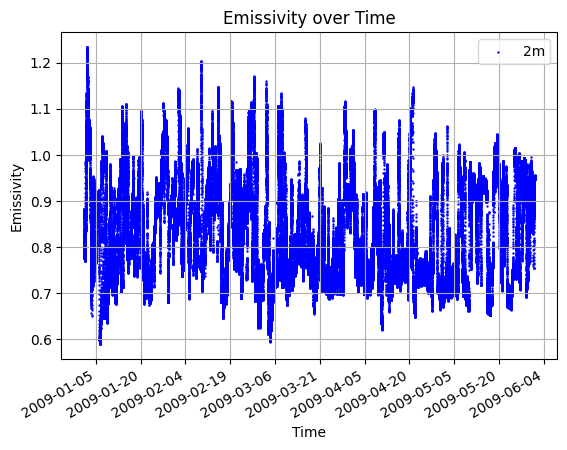

In [39]:
## Plot e_sky over time
plt.scatter(filtered_df.index, filtered_df['eps2'], label='2m', s=0.5, color='blue')
# plt.scatter(towermet_df.index[epsmask6], towermet_df['eps6'][epsmask6], label='6m', s=0.5, color='cyan')
# plt.scatter(towermet_df.index[epsmask10], towermet_df['eps10'][epsmask10], label='10m', s=0.5, color='red')


# Format the plot
plt.xlabel('Time')
plt.ylabel('Emissivity')
plt.title('Emissivity over Time')
plt.legend()
plt.grid()

# Set ticks at regular intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Show a tick every 15 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the date
plt.gcf().autofmt_xdate()

# Save plot as .png
# plt.savefig('emissivity.png')

### Expected vs Measured DLR

Axis start at zero

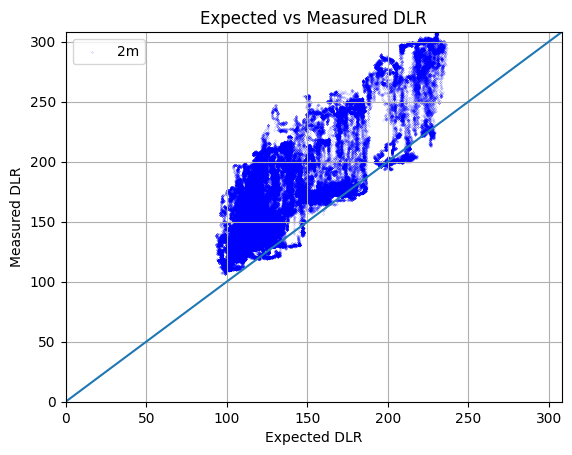

In [40]:
## Plot expected DLR vs measured DLR
plt.scatter(filtered_df['DLR2'], filtered_df['LWTotalDownwelling[W/m^2]'], label='2m', s=0.01, color='blue')
# plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask6], towermet_df['DLR6'][DLRmask6], label='6m', s=0.5, color='cyan')
# plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask10], towermet_df['DLR10'][DLRmask10], label='10m', s=0.5, color='red')

# Calculate the maximum value for x and y
max_value = max(np.nanmax(filtered_df['LWTotalDownwelling[W/m^2]']), np.nanmax(filtered_df['DLR2']))
plt.xlim(0, max_value)
plt.ylim(0, max_value)
plt.plot([0,max_value],[0,max_value])

# Format the plot
plt.xlabel('Expected DLR')
plt.ylabel('Measured DLR')
plt.title('Expected vs Measured DLR')
plt.grid()
plt.legend()

# Save plot as .png
# plt.savefig('exp-vs-measured-DLR.png')

### Expected vs Measured DLR

Grid fitted to data (i.e. zoomed in)

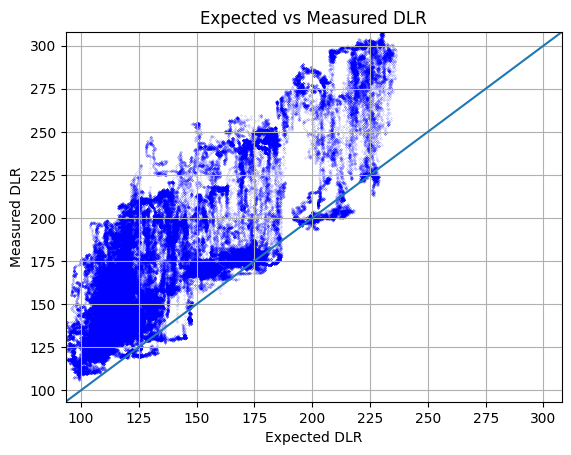

In [41]:
## Plot expected DLR vs measured DLR
plt.scatter(filtered_df['DLR2'], filtered_df['LWTotalDownwelling[W/m^2]'], label='2m', s=0.01, color='blue')
# plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask6], towermet_df['DLR6'][DLRmask6], label='6m', s=0.5, color='cyan')
# plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask10], towermet_df['DLR10'][DLRmask10], label='10m', s=0.5, color='red')

# Calculate the maximum value for x and y
max_value = max(np.nanmax(filtered_df['LWTotalDownwelling[W/m^2]']), np.nanmax(filtered_df['DLR2']))
min_value = min(np.nanmin(filtered_df['LWTotalDownwelling[W/m^2]']), np.nanmin(filtered_df['DLR2']))
plt.xlim(min_value, max_value)
plt.ylim(min_value, max_value)
plt.plot([min_value,max_value],[min_value,max_value])


# Format the plot
plt.xlabel('Expected DLR')
plt.ylabel('Measured DLR')
plt.title('Expected vs Measured DLR')
plt.grid()
# Save plot as .png
# plt.savefig('exp-vs-measured-DLR.png')

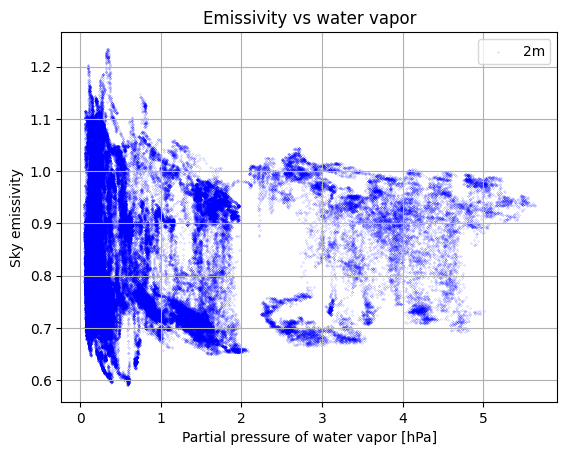

In [42]:
# Plot expected Emissivity vs Water vapor pressure
plt.scatter(filtered_df['Pw2'], filtered_df['eps2'], label='2m', s=0.01, color='blue')


# Format the plot
plt.xlabel('Partial pressure of water vapor [hPa]')
plt.ylabel('Sky emissivity')
plt.title('Emissivity vs water vapor')
plt.legend()
plt.grid()


# Save plot as .png
# plt.savefig('exp-vs-measured-DLR.png')

In [43]:
max(filtered_df['2MRH[%]']), max(filtered_df['Pw2'])

(97.7, 5.6387564963662395)

In [44]:
if 'isnight' in filter_keys:
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['LocalTime'], data_df['theta_z'], label='all', color='blue')
    plt.plot(filtered_df['LocalTime'], filtered_df['theta_z'], label='night', color='red')

    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Show a tick every 5 days
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the date

    plt.xlabel('Date')
    plt.ylabel('Degrees')
    plt.title('Solar Zenith Angle')

    plt.grid(True)

    plt.gcf().autofmt_xdate()

    plt.legend()